In [ ]:
!pip install tensorflow keras scikit-fuzzy opencv-python matplotlib numpy scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 11.1 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()   #Upload your Kaggle dataset zip file here


Saving archive.zip to archive.zip


In [ ]:
import zipfile, os

with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("lung_disease")  # this will create the folder 'lung_disease'


In [ ]:
os.listdir("lung_disease")


['Lung X-Ray Image']

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical


In [ ]:
# Robust image loader for Colab (run this whole cell)
import os, cv2, numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

base_path = "lung_disease"   # change if your extracted folder has a different name

# allowed image extensions (lowercase)
allowed_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}

X = []
y_labels = []            # numeric labels
class_name_to_label = {} # map folder name -> numeric label
label_counter = 0
skipped_files = []

# Walk recursively through base_path
if not os.path.exists(base_path):
    raise FileNotFoundError(f"Base path not found: {base_path}. Check your folder name and path.")

for root, dirs, files in os.walk(base_path):
    # Determine class name as the last folder in the path relative to base_path
    # If root == base_path, we skip files directly inside root (they are not labelled)
    if os.path.abspath(root) == os.path.abspath(base_path):
        # skip files directly under base folder (we expect class subfolders)
        continue

    class_name = os.path.basename(root).strip()
    if class_name == "":
        continue

    # Register class name -> label
    if class_name not in class_name_to_label:
        class_name_to_label[class_name] = label_counter
        label_counter += 1

    label = class_name_to_label[class_name]

    for fname in files:
        _, ext = os.path.splitext(fname)
        if ext.lower() not in allowed_exts:
            # Ignore non-image files
            continue

        fpath = os.path.join(root, fname)
        # Read image in grayscale
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        if img is None:
            skipped_files.append(fpath)
            continue

        try:
            img = cv2.resize(img, (128, 128))  # resize to 128x128
        except Exception as e:
            skipped_files.append(f"{fpath} (resize error: {e})")
            continue

        X.append(img)
        y_labels.append(label)

# Diagnostics
print("Classes found:", class_name_to_label)
print("Total images found (loaded):", len(X))
print("Total skipped files (unreadable/non-image):", len(skipped_files))
if len(skipped_files) > 0:
    print("Examples of skipped files (up to 10):")
    for s in skipped_files[:10]:
        print("  ", s)

if len(X) == 0:
    # helpful diagnostics to show what's in the base_path
    print("\n>>> No images were loaded. Directory listing of base_path:")
    for item in os.listdir(base_path):
        print(" -", item)
    raise RuntimeError("No images loaded. Check that your dataset contains image files inside subfolders and that base_path variable is correct.")

# Convert to numpy arrays and normalize
X = np.array(X, dtype=np.float32).reshape(-1, 128, 128, 1) / 255.0
y_labels = np.array(y_labels, dtype=np.int32)
y_onehot = to_categorical(y_labels, num_classes=len(class_name_to_label))

print("X shape:", X.shape)
print("y_labels shape:", y_labels.shape)
print("y_onehot shape:", y_onehot.shape)

# Optional: split into train/test with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y_labels
)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

# Save outputs to variables for next steps
class_names = {v:k for k,v in class_name_to_label.items()}  # label->name mapping
print("Label to class name mapping example:", class_names)


Classes found: {'Lung X-Ray Image': 0, 'Viral Pneumonia': 1, 'Lung_Opacity': 2, 'Normal': 3}
Total images found (loaded): 3475
Total skipped files (unreadable/non-image): 0
X shape: (3475, 128, 128, 1)
y_labels shape: (3475,)
y_onehot shape: (3475, 4)
Train: (2780, 128, 128, 1) (2780, 4)
Test: (695, 128, 128, 1) (695, 4)
Label to class name mapping example: {0: 'Lung X-Ray Image', 1: 'Viral Pneumonia', 2: 'Lung_Opacity', 3: 'Normal'}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=16,
                    validation_data=(X_test, y_test))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\n✅ Test Accuracy:", round(test_acc * 100, 2), "%")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 86s 460ms/step - accuracy: 0.5492 - loss: 0.9340 - val_accuracy: 0.8058 - val_loss: 0.5017
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 83s 476ms/step - accuracy: 0.7952 - loss: 0.4847 - val_accuracy: 0.7813 - val_loss: 0.5831
Epoch 3/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 79s 455ms/step - accuracy: 0.8504 - loss: 0.4067 - val_accuracy: 0.8403 - val_loss: 0.3508
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 80s 462ms/step - accuracy: 0.8683 - loss: 0.3265 - val_accuracy: 0.8475 - val_loss: 0.3632
Epoch 5/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 82s 474ms/step - accuracy: 0.8888 - loss: 0.2989 - val_accuracy: 0.8489 - val_loss: 0.3572
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 139s 460ms/step - accuracy: 0.8913 - loss: 0.2762 - val_accuracy: 0.8676 - val_loss: 0.3507
Epoch 7/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 82s 460ms/step - accuracy: 0.9009 - loss: 0.2400 - val_accuracy: 0.8719 - val_loss: 0.2998
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 79s 456ms/step - accuracy: 0.9103 - loss: 

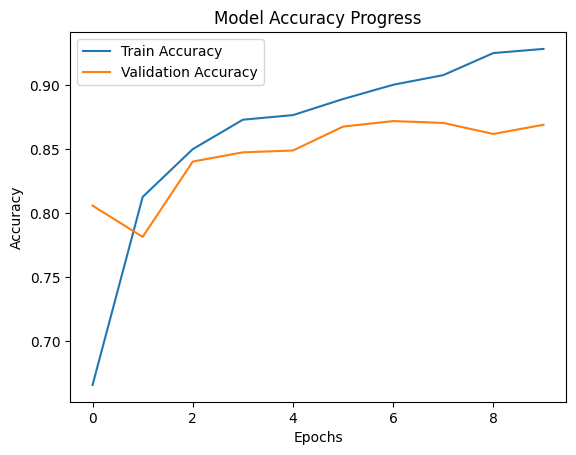

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Progress')
plt.show()


In [ ]:
!pip install scikit-fuzzy
import numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl


In [ ]:
# Get CNN probabilities
pred_probs = model.predict(X_test)

# Example: take first test sample
sample_pred = pred_probs[0]
print("CNN Predicted Probabilities:", sample_pred)

# Class names for reference
print("Class order:", class_names)


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step
CNN Predicted Probabilities: [1.1928292e-10 4.3740741e-08 9.4150144e-01 5.8498610e-02]
Class order: {0: 'Lung X-Ray Image', 1: 'Viral Pneumonia', 2: 'Lung_Opacity', 3: 'Normal'}


In [ ]:
# Input fuzzy variable: confidence (0 to 1)
confidence = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'confidence')

# Output fuzzy variable: severity (0 to 100)
severity = ctrl.Consequent(np.arange(0, 101, 1), 'severity')

# Define fuzzy membership functions
confidence['low'] = fuzz.trimf(confidence.universe, [0, 0, 0.5])
confidence['medium'] = fuzz.trimf(confidence.universe, [0.3, 0.5, 0.7])
confidence['high'] = fuzz.trimf(confidence.universe, [0.6, 1, 1])

severity['normal'] = fuzz.trimf(severity.universe, [0, 0, 40])
severity['mild'] = fuzz.trimf(severity.universe, [30, 50, 70])
severity['severe'] = fuzz.trimf(severity.universe, [60, 100, 100])


In [ ]:
rule1 = ctrl.Rule(confidence['low'], severity['normal'])
rule2 = ctrl.Rule(confidence['medium'], severity['mild'])
rule3 = ctrl.Rule(confidence['high'], severity['severe'])

severity_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
severity_sim = ctrl.ControlSystemSimulation(severity_ctrl)


In [ ]:
# Get CNN’s highest confidence
cnn_confidence = np.max(sample_pred)

severity_sim.input['confidence'] = cnn_confidence
severity_sim.compute()

print("CNN confidence:", round(cnn_confidence, 3))
print("Fuzzy severity output:", round(severity_sim.output['severity'], 2))


CNN confidence: 0.942
Fuzzy severity output: 86.42


In [ ]:
if severity_sim.output['severity'] < 40:
    diagnosis = "Normal"
elif severity_sim.output['severity'] < 70:
    diagnosis = "Mild Disease Detected"
else:
    diagnosis = "Severe Disease Detected"

print("🩺 Final Fuzzy Diagnosis:", diagnosis)


🩺 Final Fuzzy Diagnosis: Severe Disease Detected


In [ ]:
import cv2, numpy as np
import skfuzzy as fuzz
import skfuzzy.control as ctrl
from tensorflow.keras.preprocessing import image

# --- Fuzzy logic setup (same as before) ---
confidence = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'confidence')
severity = ctrl.Consequent(np.arange(0, 101, 1), 'severity')

confidence['low'] = fuzz.trimf(confidence.universe, [0, 0, 0.5])
confidence['medium'] = fuzz.trimf(confidence.universe, [0.3, 0.5, 0.7])
confidence['high'] = fuzz.trimf(confidence.universe, [0.6, 1, 1])

severity['normal'] = fuzz.trimf(severity.universe, [0, 0, 40])
severity['mild'] = fuzz.trimf(severity.universe, [30, 50, 70])
severity['severe'] = fuzz.trimf(severity.universe, [60, 100, 100])

rule1 = ctrl.Rule(confidence['low'], severity['normal'])
rule2 = ctrl.Rule(confidence['medium'], severity['mild'])
rule3 = ctrl.Rule(confidence['high'], severity['severe'])

severity_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
severity_sim = ctrl.ControlSystemSimulation(severity_ctrl)


# --- Unified function ---
def predict_with_fuzzy(img_path):
    # 1️⃣ Load and preprocess the image
    img = image.load_img(img_path, color_mode='grayscale', target_size=(128,128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # 2️⃣ CNN prediction
    preds = model.predict(img_array)
    predicted_label = np.argmax(preds)
    confidence_val = np.max(preds)
    predicted_class = class_names[predicted_label]

    # 3️⃣ Apply fuzzy logic
    severity_sim.input['confidence'] = confidence_val
    severity_sim.compute()

    fuzzy_val = severity_sim.output['severity']
    if fuzzy_val < 40:
        fuzzy_diag = "Normal"
    elif fuzzy_val < 70:
        fuzzy_diag = "Mild Disease Detected"
    else:
        fuzzy_diag = "Severe Disease Detected"

    # 4️⃣ Show result
    print("🔹 CNN Predicted Class:", predicted_class)
    print("🔹 CNN Confidence:", round(confidence_val, 3))
    print("🔹 Fuzzy Severity Output:", round(fuzzy_val, 2))
    print("🩺 Final Fuzzy Diagnosis:", fuzzy_diag)
    return predicted_class, fuzzy_diag


In [ ]:
from google.colab import files
uploaded = files.upload()   # upload one image


In [ ]:
{'my_lung_image.jpg': b'...'}


In [ ]:
predict_with_fuzzy("93.jpg")
